In [ ]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import jax
from jax import grad, vmap
import jax.numpy as jnp
import torch
import tqdm
import scipy
from scipy import integrate

In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
#Exponential kernel for two inputs i.e. ID
def kernel(s,t,params):
  #K = jnp.exp(-(s-t)**2/(2*params[0]**2))
  K = (1+jnp.sqrt(5)*jnp.abs(s-t)/params[0]+5/3*jnp.abs(s-t)**2/params[0]**2)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])
  return K

In [ ]:
def kernel_u(s,t,params):
  #K = -(s-t)*kernel(s,t,params)/params[0]**2
  K = -5*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(params[0]+jnp.sqrt(5)*jnp.abs(s-t))/(3*params[0]**3)
  return K

In [ ]:
def linearize(u):
  return jnp.exp((u**3-1)/3)

def error(w,w_true):
  return jnp.linalg.norm(w-w_true)/jnp.linalg.norm(w_true)

In [ ]:
#Start and end times for space (x) and time (t)
xbegin=0
xfinal=1
#Space step
h=1/100
#Time step
x = np.arange(xbegin, xfinal+h, h)

m=len(x)-1

In [ ]:
nonlin_train1=np.zeros((m+1,1))


nonlin_train1[:,0] = jnp.cbrt(3*jnp.log(jnp.exp(x)*jnp.cosh(-x))+1)

In [ ]:
nonlin_train = nonlin_train1

In [ ]:
#Kernel matrix as function of one vector
def K_Matrix(X,Y,params,reg=True,nugget=10**-15):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())

  K_matrix=np.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Derivative wrt to u
def K_du(X,Y,params,reg=False,nugget=10**-10):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_du = vmap(lambda s, t: kernel_u(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_du = np.reshape(K_du,(size,size2))

  if reg==True and size==size2:
    K_du+=+nugget*jnp.eye(size)
  return K_du

In [ ]:
params = jnp.array([0.1])
K = K_Matrix(nonlin_train,nonlin_train,params)
K_u = K_du(nonlin_train,nonlin_train,params)

In [ ]:
train_size = len(nonlin_train[:,0])
train = nonlin_train[:,0].reshape((train_size,1))

In [ ]:
a0 = 0
Z0 = nonlin_train1[:,0]
B = K_u@jnp.linalg.inv(K)
B2 = B.T@B

In [ ]:
def loss_function(Z,a):

  lambda2 = 100000
  lambda3 = 1000000000

  #L = Z.dot(jnp.linalg.inv(K)@Z)
  L = 0
  L += a**2

  #L += lambda2*jnp.linalg.norm(Z+a*(B@Z)/nonlin_train[:,0]**2)**2

  L += lambda3*jnp.linalg.norm(Z[0]-1)**2

  return L

In [ ]:
def loss_function2(Z,a):

  lambda2 = 100000

  L = Z.dot(jnp.linalg.inv(K)@Z)

  L = lambda2*jnp.linalg.norm(Z+a*(B@Z)/nonlin_train[:,0]**2)**2

  return L

In [ ]:
def grad_function(Z,a):

  lambda2 = 100000
  lambda3 = 1000000000

  #grad_Z = 2*jnp.linalg.inv(K)@Z
  grad_Z = jnp.zeros(train_size)
  grad_Z = grad_Z.at[0].set(grad_Z[0]+2*lambda3*(Z[0]-1))

  #grad_Z += lambda2*(2*Z+a*((B+B.T)@Z)/nonlin_train[:,0]**2+a**2*((B2+B2.T)@Z)/nonlin_train[:,0]**4)

  return grad_Z

In [ ]:
def gradient_descent(Z0,a0,niterations,init_learning_rate=0.001):
  Z=Z0
  a=a0
  lambda2 = 100000
  learning_rate=init_learning_rate
  for n in range(niterations):
    gradient = grad_function(Z,a)
    grad_Z = gradient+grad(loss_function2)(Z,a)
    Z-=learning_rate/np.sqrt(np.sum(grad_Z*grad_Z,axis=None))*grad_Z
    a = -(1+(lambda2*jnp.linalg.norm((B@Z)*1/nonlin_train[:,0]**2)**2))/(lambda2*(Z.dot((1/nonlin_train[:,0]**2)*(B@Z))))
    print(loss_function(Z,a)+loss_function2(Z,a))
  return Z,a


In [ ]:
v = gradient_descent(Z0,a0,10000,init_learning_rate=0.0001)

14314834.125748606
14309618.84437174
14304330.184274297
14298970.039457968
14293540.288953733
14288042.795658816
14282479.405204922
14276851.944858182
14271162.222456288
14265412.025382325
14259603.119583422
14253737.248631997
14247816.132835269
14241841.468395527
14235814.926623235
14229738.15320485
14223612.767530156
14217440.362077463
14211222.501863645
14204960.723955486
14198656.537048938
14192311.421114653
14185926.827112433
14179504.176775094
14173044.862464186
14166550.247095417
14160021.66413792
14153460.41768393
14146867.782593045
14140245.004706068
14133593.301133018
14126913.860611346
14120207.843934936
14113476.384452706
14106720.588635847
14099941.536711944
14093140.283365253
14086317.858500144
14079475.268066883
14072613.494948018
14065733.499901198
14058836.222559387
14051922.582481813
14044993.480257355
14038049.798654266
14031092.403815359
14024122.146494163
14017139.86333116
14010146.378163844
14003142.503370719
13996129.041242274
13989106.785378829
13982076.52210907

KeyboardInterrupt: 

In [ ]:
w = gradient_descent(w[0],w[1],10000,init_learning_rate=0.001)

Streaming output truncated to the last 5000 lines.
5485.481502646749
5697.3610752730165
5485.393554899285
5697.269490431498
5485.3056101510265
5697.177908648997
5485.217668407464
5697.08632994116
5485.129729669212
5696.994754291694
5485.041793933069
5696.903181713257
5484.95386120287
5696.811612197906
5484.865931474302
5696.720045742213
5484.778004755423
5696.628482355726
5484.690081032352
5696.536922037365
5484.602160315505
5696.445364782845
5484.514242598403
5696.353810593967
5484.42632788681
5696.262259463546
5484.338416179361
5696.170711400887
5484.250507476767
5696.079166406013
5484.1626017764065
5695.9876244671295
5484.07469907377
5695.8960856038875
5483.986799381831
5695.804549797497
5483.898902689662
5695.713017051674
5483.811008998208
5695.621487378084
5483.7231183122685
5695.529960767129
5483.635230622348
5695.438437213199
5483.547345940268
5695.346916733481
5483.459464263205
5695.255399307331
5483.371585579412
5695.163884950134
5483.28370989783
5695.072373652794
5483.1958372

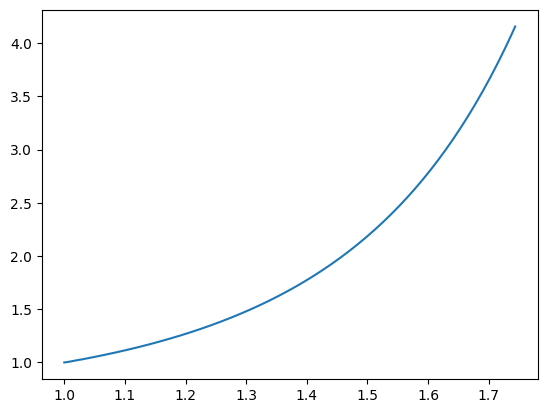

In [ ]:
plt.plot(nonlin_train[:,0],w[0])

In [ ]:
max(w[0])

Array(4.15606962, dtype=float64)

In [ ]:
w[0]

Array([1.00000384, 1.00885768, 1.01991997, 1.02953076, 1.04050523,
       1.05086739, 1.06212049, 1.07297435, 1.08466163, 1.09597585,
       1.10812509, 1.11992233, 1.1325479 , 1.1448508 , 1.15797199,
       1.17080068, 1.18443946, 1.19781415, 1.21199352, 1.22593539,
       1.24067911, 1.25521038, 1.27054305, 1.28568698, 1.30163411,
       1.31741499, 1.33400304, 1.35044627, 1.36770271, 1.38483479,
       1.40278814, 1.42063671, 1.43931662, 1.45791052, 1.47734778,
       1.49671707, 1.51694369, 1.53711971, 1.55816896, 1.57918437,
       1.60109085, 1.62297968, 1.64577936, 1.66857704, 1.69230732,
       1.71605079, 1.74075059, 1.76547829, 1.79118806, 1.81694004,
       1.84370188, 1.87051985, 1.89837753, 1.9263049 , 1.95530396,
       1.98438596, 2.01457378, 2.04485747, 2.07628334, 2.10781772,
       2.14053292, 2.17336902, 2.2074269 , 2.24161782, 2.27707389,
       2.31267493, 2.34958694, 2.38665565, 2.42508369, 2.46368   ,
       2.50368659, 2.54387288, 2.58552307, 2.62736426, 2.67072

In [ ]:
loss_function(linearize(nonlin_train[:,0]),-1)+loss_function2(linearize(nonlin_train[:,0]),-1)

Array(3627.73411464, dtype=float64)

In [ ]:
linearize(nonlin_train[:,0]).dot(jnp.linalg.inv(K)@linearize(nonlin_train[:,0]))

Array(28.21663378, dtype=float64)

In [ ]:
loss_function2(linearize(nonlin_train[:,0]),-1)

Array(3626.73411464, dtype=float64)

In [ ]:
w[1]

Array(-0.99759937, dtype=float64)

Text(0.5, 1.0, 'Recovered Transform, CGC')

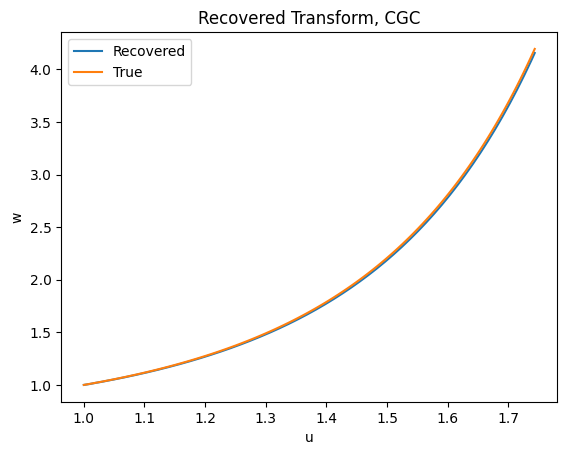

In [ ]:
plt.plot(nonlin_train[:,0],w[0])
plt.plot(nonlin_train[:,0],linearize(nonlin_train[:,0]))
plt.xlabel('u')
plt.ylabel('w')
plt.legend(['Recovered','True'])
plt.title('Recovered Transform, CGC')

Text(0.5, 1.0, 'Recovery of Linear PDE, CGC')

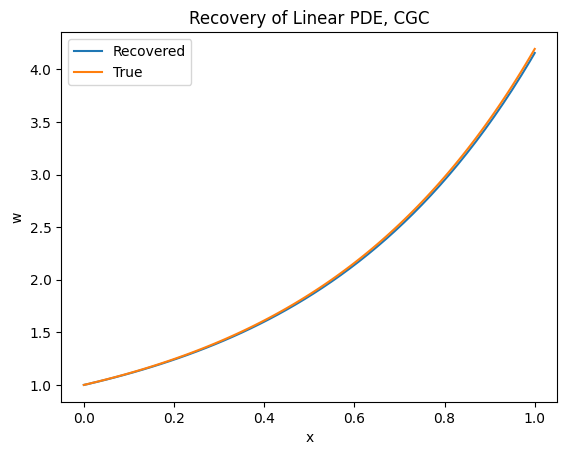

In [ ]:
#params = jnp.array([28])
plt.plot(x,w[0])
plt.plot(x,linearize(nonlin_train[:,0]))
plt.xlabel('x')
plt.ylabel('w')
plt.legend(['Recovered','True'])
plt.title('Recovery of Linear PDE, CGC')

In [ ]:
max(linearize(nonlin_train[:,0]))

Array(4.19452805, dtype=float64)

In [ ]:
error(w[0],linearize(nonlin_train[:,0]))

Array(0.00892537, dtype=float64)